In [1]:
# Importerer pakker:
import numpy as np
from diabetessims import *
import matplotlib.pyplot as plt

# Best Bolus Heatplot

In [ ]:
from matplotlib import cm, colors
meals = np.linspace(20, 200, 90)

patient = baseline_patient(1, Gbar = 6, model = MVP)
penalty, us = patient.dense_meal_bolus(meals, max_bolus=15000, n = 80) # penalty[i,j] : penalty for meal[i] and bolus[j]
plt.title("Optimal Bolus for Meals")
plt.xlabel("Meal size [g carbs]")
plt.ylabel("Bolus size [U]")
im = plt.imshow(penalty.T[::-1], cmap=cm.rainbow, extent = [meals[0], meals[-1], us[0]/1000, us[-1]/1000], aspect = "auto", norm=colors.LogNorm())
plt.colorbar(im)
plt.plot(meals, us[np.argmin(penalty, 1)]/1000, color = "black", linewidth = 5, label = "Optimal Bolus")
plt.legend()

[7.912103842924397, 7.184950704212943, 6.763110376522478, 6.675785635392715, 6.592313377517988, 6.51240106646763, 6.43578736686419, 6.362237904668275, 6.29154172082284, 6.223508286755792, 6.157964978422559, 6.094754927056766, 6.033735181325708, 5.974775128409044, 5.917755131543441, 5.862565349471564, 5.734665806930845, 5.576191937550677, 5.421033663678088, 5.268943114142832, 5.119689035996199, 4.973054780641158, 4.8288365101632476, 4.686841587182859, 4.546887116873823, 4.408798613980468, 4.272408770910497, 4.137556305426754, 4.004084868206627, 3.871841991645915, 3.7406780617833113, 3.61044529510743, 3.480996701240507, 3.3521850109902336, 3.223861546891604, 3.095875009926149, 2.968070151319158, 2.8402862917649467, 2.712355641527012, 2.5841013627577274, 2.455335298852829, 2.325855272895977, 2.195441825570603, 2.0638542182494812, 1.9308254630331871, 1.7960560483973431, 1.6592058908607836, 1.519883833292646, 1.3776336841661345, 1.2319152701484266]


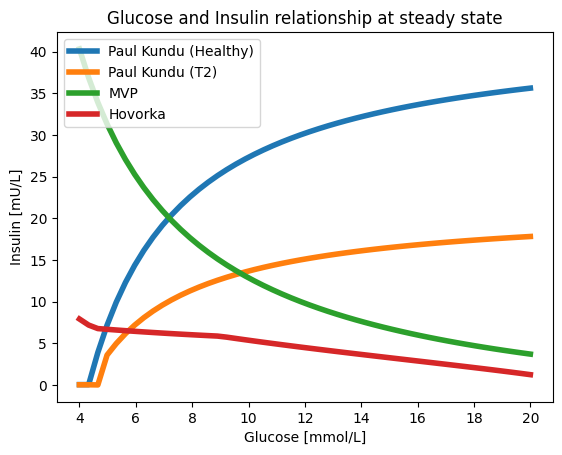

In [39]:
G_arr = np.linspace(4, 20)

p_mvp = Patient(1, model = MVP)
p_ehm = Patient(1, model = HM)
pan0 = PKPM()
pan2 = PKPM(patient_type=2)

up0 = [pan0.steadystate(Gi)[1] for Gi in G_arr]
up2 = [pan2.steadystate(Gi)[1] for Gi in G_arr]
umvp = [p_mvp.steadystate(uP = 0, G = Gi)[1] for Gi in G_arr]
uhm = [p_ehm.steadystate(uP = 0, G = Gi)[1] for Gi in G_arr]
print(uhm)

w = 4
plt.plot(G_arr, up0, label = "Paul Kundu (Healthy)", linewidth = w)
plt.plot(G_arr, up2, label = "Paul Kundu (T2)",  linewidth = w)

plt.plot(G_arr, umvp, label = "MVP", linewidth = w)
plt.plot(G_arr, uhm, label = "Hovorka",  linewidth = w)
plt.xlabel("Glucose [mmol/L]")
plt.ylabel("Insulin [mU/L]")
plt.title("Glucose and Insulin relationship at steady state")
plt.legend()

# PKPM ss

Text(0.5, 0, 'Relative Derivatives')

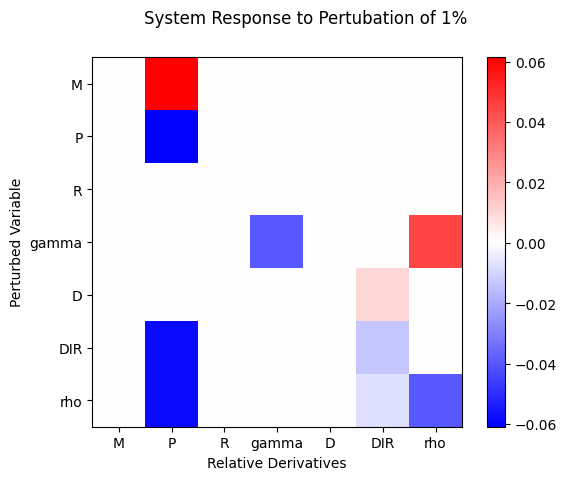

In [2]:
G = find_ss(HM).root
pk = PKPM()
x0, isr0 = pk.steadystate(G)
scale = 1.01
n = len(x0)
dx = np.zeros((n, n))
isr = np.zeros((n))
pk.update_state(x0)
for i in range(n):
    x_perturb = np.copy(x0)
    x_perturb[i] *= scale
    pk.update_state(x_perturb)
    dx[i], isr[i] = pk.sys(G)
    dx[i] /= x_perturb

isr /= isr0

fig, ax = plt.subplots()
im = ax.imshow(dx, cmap="bwr")
fig.colorbar(im)
labels = pk.state_keys
fig.suptitle(f"System Response to Pertubation of {int(((scale-1)*100))}%")
ax.set_xticks(np.arange(n),labels)
ax.set_ylabel("Perturbed Variable")
ax.set_yticks(np.arange(n),labels)
ax.set_xlabel("Relative Derivatives")


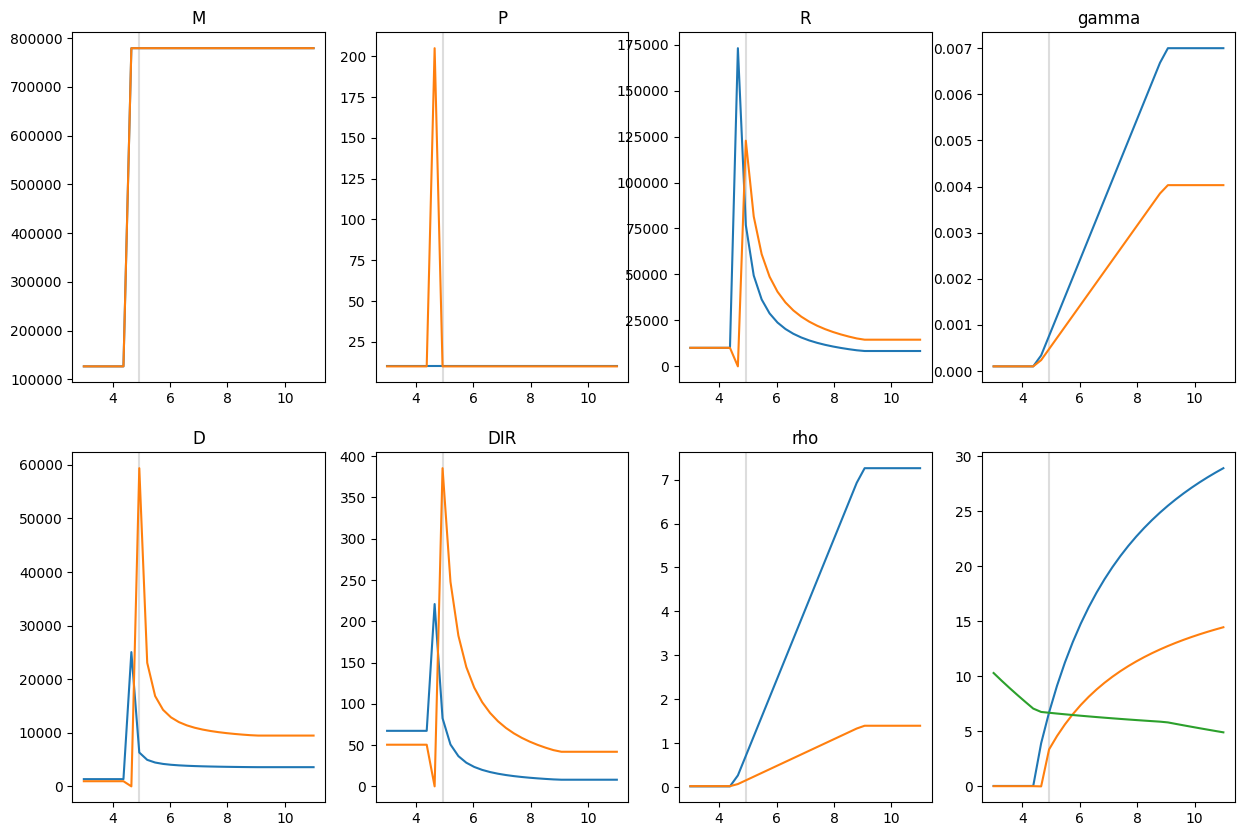

In [3]:
ph = baseline_patient(0, HM)
pkh = ph.pancreasObj
pt2 = baseline_patient(2, HM)
pk2 = pt2.pancreasObj

Gs = np.linspace(3, 11, 30)
ss_mat = np.vstack([np.hstack(pkh.steadystate(G)) for G in Gs])
ss_mat2 = np.vstack([np.hstack(pk2.steadystate(G)) for G in Gs])
req_u = np.array([ph.ssinv(G) for G in Gs])
idx = np.argmin(np.abs(req_u - ss_mat[:, -1]))
intersect = Gs[idx]
fig, ax = plt.subplots(2, 4, figsize = (15, 10))
for i in range(8):
    if i < 7:
        ax[i//4, i%4].set_title(pkh.state_keys[i])
    ax[i//4, i%4].axvline(intersect, color = "#ddd")
    ax[i//4, i%4].plot(Gs, ss_mat[:, i])
    ax[i//4, i%4].plot(Gs, ss_mat2[:, i])

ax[1, 3].plot(Gs, req_u)

# Hovorka w. noise

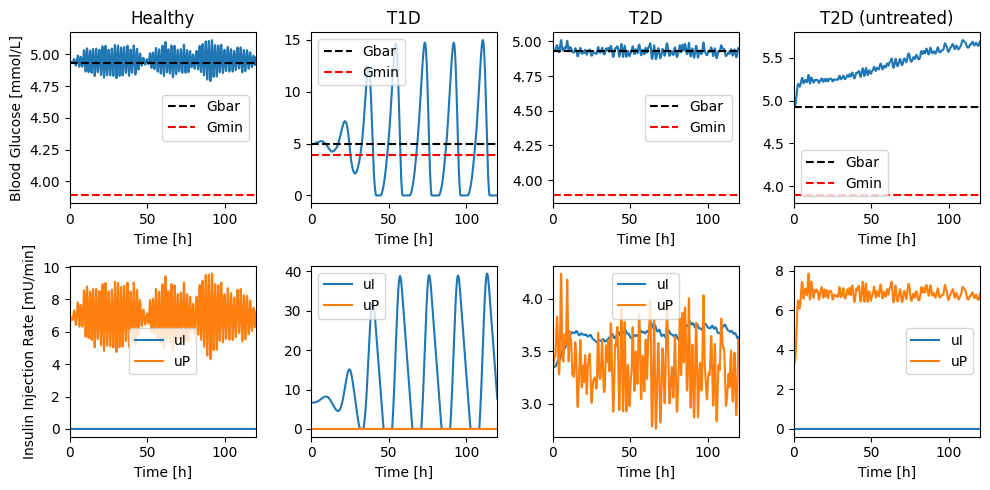

In [40]:
import numpy as np
from diabetessims import *
import matplotlib.pyplot as plt

d = 5 # number of days
noise = np.random.normal(loc = 0, scale = 0.1, size=d*1440) # generate noise

fig, ax = plt.subplots(2, 4, figsize = (10, 5))
for i in range(4):
    p = baseline_patient(min(2,i), model = HM, timestep = 1, n_pancreas  = 10) # initialize patient 
    if i == 3: 
        info = p.simulate(ds = noise, uIs = np.zeros(len(noise))) # simulate untreated t2d
    else:
        info = p.simulate(ds=noise)
    ax[0,i].plot(info["t"]/60,info["G"])
    ax[1,i].plot(info["t"][:-1]/60,info["uI"], label = "uI")
    ax[1,i].plot(info["t"][:-1]/60,info["uP"], label = "uP")
    #ax[0, i].set_ylim(3.5, 6)
    ax[0,i].axhline(p.Gbar, color="000", linestyle="--", label = "Gbar")
    ax[0,i].axhline(p.Gmin, color="r", linestyle="--", label = "Gmin")

    ax[0, i].set_xlim(0, d*24)
    ax[1, i].set_xlim(0, d*24)

    ax[0,i].set_xlabel("Time [h]")
    ax[1,i].set_xlabel("Time [h]")

    ax[0,i].legend()
    ax[1,i].legend()
ax[0,0].set_ylabel("Blood Glucose [mmol/L]")
ax[1,0].set_ylabel("Insulin Injection Rate [mU/min]")
ax[0, 0].set_title("Healthy")
ax[0, 1].set_title("T1D")
ax[0, 2].set_title("T2D")
ax[0, 3].set_title("T2D (untreated)")

fig.tight_layout()

# Simulation

### Preparing Data

In [5]:
t = 1
p0 = baseline_patient(0, model = HM, timestep = t, n_pancreas  = 10)
p1 = baseline_patient(1, model = HM, timestep = t)
p2 = baseline_patient(2, model = HM, timestep = t,  n_pancreas  = 10)
p22 = baseline_patient(2, model = HM, timestep = t,  n_pancreas  = 10)
p2.pancreasObj.W = 0.75 # less severe t2d
p22.pancreasObj.W = 0.33 # more severe t2d

day1 = np.array([[50, 6,6.25], [20, 10, 10.25], [70, 12.5, 12.75], [20, 15, 15.25], [80, 18.5, 18.75], [20, 20, 20.25]])
day2 = np.array([[100, 7,7.25], [80, 13.5, 12.75], [100, 18.5, 18.75]])
day3 = np.array([[50, 7.5,7.75], [20, 10, 10.25], [50, 15, 15.25], [70, 18.5, 18.75], [20, 21, 21.25]])
day4 = np.array([[50, 6,6.25], [20, 10, 10.25], [50, 14, 14.25], [70, 18.5, 18.75], [20, 21, 21.25]])
day5 = np.array([[20, 9, 9.25], [20, 10, 10.25], [40, 15, 15.25], [100, 18.5, 18.75], [70, 21, 21.25]])
day6 = np.array([[60, 9, 9.25], [20, 12, 12.25], [40, 15, 15.25], [100, 18.5, 18.75], [20, 21, 21.25]])
day7 = np.array([[80, 9, 9.25], [80, 14, 14.25], [80, 18.5, 18.75]])
day8 = np.array([[50, 6,6.25], [20, 10, 10.25], [50, 14, 14.25], [70, 18.5, 18.75], [20, 21, 21.25]])
day9 = np.array([[20, 9, 9.25], [20, 10, 10.25], [40, 15, 15.25], [100, 18.5, 18.75], [70, 21, 21.25]])
day10 = np.array([[40, 9, 9.25], [40, 12, 12.25], [40, 15, 15.25], [100, 18.5, 18.75], [20, 21, 21.25]])
day11 = np.array([[80, 8, 8.25], [70, 14, 14.25], [90, 18.5, 18.75]])
day12 = np.array([[30, 8, 8.25], [20, 11, 10.25], [50, 15, 15.25], [90, 18.5, 18.75], [50, 21, 21.25]])
day13 = np.array([[60, 8, 8.25], [20, 12.5, 12.75], [30, 15, 15.25], [40, 17.5, 17.75], [100, 21, 21.25]])
day14 = np.array([[70, 8.5, 8.75], [90, 14.5, 14.75], [80, 19.5, 19.75]])
day15 = np.array([[30, 8, 8.25], [30, 10, 10.25], [50, 15, 15.25], [100, 18.5, 18.75], [70, 21, 21.25]])

days = [day1, day2, day3, day4, day5, day6, day7, day8, day9, day10, day11, day12, day13, day14, day15]
initial_params = cohen_coon(p1.Gbar, t, p.tausc)
diff_meal_sizes = np.unique(np.hstack([d[:, 0] for d in days])) 


### Finding Optimal Bolus

In [6]:
# values have been precomputed, original code is outcommented.
#best_bolusT1 = dict(zip(diff_meal_sizes, p1.best_bolus(diff_meal_sizes, max_bolus = 5000))) 
best_bolusT1 =  {20.0: 727.832542595418, 30.0: 1222.9079520227992, 40.0: 1633.739536412122, 50.0: 1956.913249496265, 60.0: 2166.666598641178, 70.0: 2427.3596068432, 80.0: 2636.686470214291, 90.0: 2832.9805507359106, 100.0: 3018.3672630769674}
print("T1:", best_bolusT1)
#best_bolusT2 = dict(zip(diff_meal_sizes, p2.best_bolus(diff_meal_sizes, max_bolus = 2500)))
best_bolusT2 = {20.0: 134.07805130660785, 30.0: 94.97058297221425, 40.0: -204.91501795284645, 50.0: -204.91502121769645, 60.0: -204.91501563272266, 70.0: -204.91501605367384, 80.0: -204.91501631284854, 90.0: -204.9150165172791, 100.0: -204.91501660460395}
print("T2 (less severe):", best_bolusT2)
#best_bolusT22 = dict(zip(diff_meal_sizes, p22.best_bolus(diff_meal_sizes, max_bolus = 2500)))
best_bolusT22 =   {20.0: 636.3180691797022, 30.0: 746.2490586926289, 40.0: 851.2559891225939, 50.0: 921.7994871625729, 60.0: 767.8709551909544, 70.0: 610.9192881651848, 80.0: 506.60601650326834, 90.0: 449.8576944309577, 100.0: 412.16769218537667}
print("T2 (more2 severe):", best_bolusT22)

bolus_arr_T1 = [np.array([[best_bolusT1[m[0]], m[1]] for m in day]) for day in days]
bolus_arr_T2 = [np.array([[best_bolusT2[m[0]], m[1]] for m in day]) for day in days]
bolus_arr_T22 = [np.array([[best_bolusT22[m[0]], m[1]] for m in day]) for day in days]

ds = [timestamp_arr(day, t, h = 24) for day in days]
uIs1 = [ReLU(timestamp_arr(bolus, t, fill = None, h = 24)) for bolus in bolus_arr_T1]
uIs2 = [ReLU(timestamp_arr(bolus, t, fill = None, h = 24)) for bolus in bolus_arr_T2]
uIs22 = [ReLU(timestamp_arr(bolus, t, fill = None, h = 24)) for bolus in bolus_arr_T22]


n_days = 30
days_rand = np.random.randint(0, 10, n_days, dtype=int) # Generate order of days in training set
t_arr = np.linspace(0, 5*24, 1+int(n_days*1440/t))
ds_rand = np.hstack([ds[i] for i in days_rand]) 
uIs1_rand = np.hstack([uIs1[i] for i in days_rand])
uIs2_rand = np.hstack([uIs2[i] for i in days_rand])
uIs22_rand = np.hstack([uIs22[i] for i in days_rand])

T1: {20.0: 727.832542595418, 30.0: 1222.9079520227992, 40.0: 1633.739536412122, 50.0: 1956.913249496265, 60.0: 2166.666598641178, 70.0: 2427.3596068432, 80.0: 2636.686470214291, 90.0: 2832.9805507359106, 100.0: 3018.3672630769674}
T2 (less severe): {20.0: 134.07805130660785, 30.0: 94.97058297221425, 40.0: -204.91501795284645, 50.0: -204.91502121769645, 60.0: -204.91501563272266, 70.0: -204.91501605367384, 80.0: -204.91501631284854, 90.0: -204.9150165172791, 100.0: -204.91501660460395}
T2 (more2 severe): {20.0: 636.3180691797022, 30.0: 746.2490586926289, 40.0: 851.2559891225939, 50.0: 921.7994871625729, 60.0: 767.8709551909544, 70.0: 610.9192881651848, 80.0: 506.60601650326834, 90.0: 449.8576944309577, 100.0: 412.16769218537667}


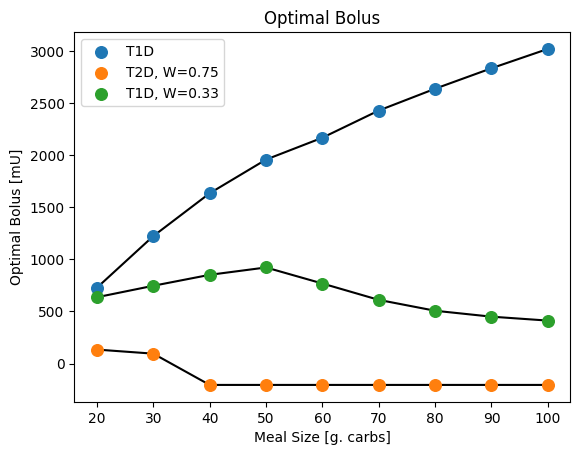

In [7]:
plt.plot(diff_meal_sizes, [best_bolusT1[m] for m in diff_meal_sizes], color = "black")
plt.plot(diff_meal_sizes, [best_bolusT2[m] for m in diff_meal_sizes], color = "black")
plt.plot(diff_meal_sizes, [best_bolusT22[m] for m in diff_meal_sizes], color = "black")

plt.scatter(diff_meal_sizes, [best_bolusT1[m] for m in diff_meal_sizes], s = 70, label ="T1D", zorder = 10)
plt.scatter(diff_meal_sizes, [best_bolusT2[m] for m in diff_meal_sizes], s = 70, label =f"T2D, W={p2.pancreasObj.W}", zorder = 10)
plt.scatter(diff_meal_sizes, [best_bolusT22[m] for m in diff_meal_sizes], s = 70, label =f"T1D, W={p22.pancreasObj.W}", zorder = 10)
plt.xlabel("Meal Size [g. carbs]")
plt.ylabel("Optimal Bolus [mU]")
plt.title("Optimal Bolus")
plt.legend()


### Optimizing PID (!!! very slow !!!)

In [8]:
#opt1 = p1.optimize_pid(ds_rand, uIs1_rand,x0 = [0.5, 1000, 100], bounds = ((0.00001, 2), (100, 5000), (80, 500)), method="Powell")
#opt1x = opt1.x
#print(opt1)
opt1x =[ 3.498e-01,  1.428e+03,  3.887e+02]

In [9]:
#opt2 = p2.optimize_pid(ds_rand, uIs2_rand,x0 = [0.5, 200, 10], bounds = ((0.00001, 3), (100, 1000), (0, 30)), method="Powell")
#opt2x = opt2.x
#print(opt2)
opt2x = [ 7.215e-03,  6.857e+02,  1.164e+01]

In [10]:
#opt22 = p22.optimize_pid(ds_rand, uIs22_rand,x0 = [0.2, 11000, 230], bounds = ((0.00001, 2), (11000, 20000), (200, 270)), method="Powell")
#opt22x = opt22.x
#print(opt22)
opt22x = [ 3.064e-01,  1.105e+04,  2.001e+02]

In [11]:
print(initial_params,opt1x, opt2x, opt22x)

(0.10483630608129675, 5.849056603773585, 0.9523809523809523) [0.3498, 1428.0, 388.7] [0.007215, 685.7, 11.64] [0.3064, 11050.0, 200.1]


### Simulating with intial and new PID-params

In [12]:
days_test = np.arange(10, 15)
uIs1_test = np.hstack([uIs1[i] for i in days_test])
uIs2_test = np.hstack([uIs2[i] for i in days_test])
uIs22_test = np.hstack([uIs22[i] for i in days_test])

ds_test = np.hstack([ds[i] for i in days_test])

p0.full_reset()
p1.full_reset()
p2.full_reset()
p22.full_reset()

p1.set_PID_params(initial_params)
p2.set_PID_params(initial_params)
p22.set_PID_params(initial_params)

for i in range(2): # repeats simulation twice, to not start at steady state
    info0 = p0.simulate(ds = ds_test)
    info1_initial = p1.simulate(ds = ds_test, uIs = uIs1_test)
    info2_initial = p2.simulate(ds = ds_test, uIs = uIs2_test)
    info22_initial = p22.simulate(ds = ds_test, uIs = uIs22_test)

p1.full_reset()
p2.full_reset()
p22.full_reset()

p1.set_PID_params(opt1x)
p2.set_PID_params(opt2x)
p22.set_PID_params(opt22x)

for i in range(2):
    info1 = p1.simulate(ds = ds_test, uIs = uIs1_test)
    info2 = p2.simulate(ds = ds_test, uIs = uIs2_test)
    info22 = p2.simulate(ds = ds_test, uIs = uIs22_test)



p2.full_reset()
p22.full_reset()

p2.set_PID_params([0,1,1])
p22.set_PID_params([0,1,1])

info2_untreated = p2.simulate(ds = ds_test)
info22_untreated = p22.simulate(ds = ds_test)

In [ ]:
def hist(G_arr, ax):
    bin_place=np.empty(len(G_arr))
    for i, G in enumerate(G_arr):
        if G <= 3:
            bin_place[i]=0
        elif 3<G<=3.9:
            bin_place[i]=1
        elif 3.9 < G <= 10:
            bin_place[i]=2
        elif 10 < G <= 13.9:
            bin_place[i]=3
        elif 13.9 < G:
            bin_place=4
    n,bins,patches=ax.hist(bin_place,bins=range(6),orientation="horizontal",align="left",density=True)
    colors=["#020249","#088ccd","#00FF7F","#78064d","#5a0000"]
    for c, p in zip(colors, patches):
        p.set_facecolor(c)
    ax.set_yticks(ticks=[0,1,2,3,4],labels=[" Very high \n (13.9 < G) ", "High \n (10 < G < 13.9) ", "Target \n (3.9 < G 10)", "Low \n (3 < G < 3.9)", "Very low \n (G < 3)"])
    ax.tick_params(axis='y', labelsize=8)
    ax.set_title("Percentage of time spent in different blood glucose ranges")
    return

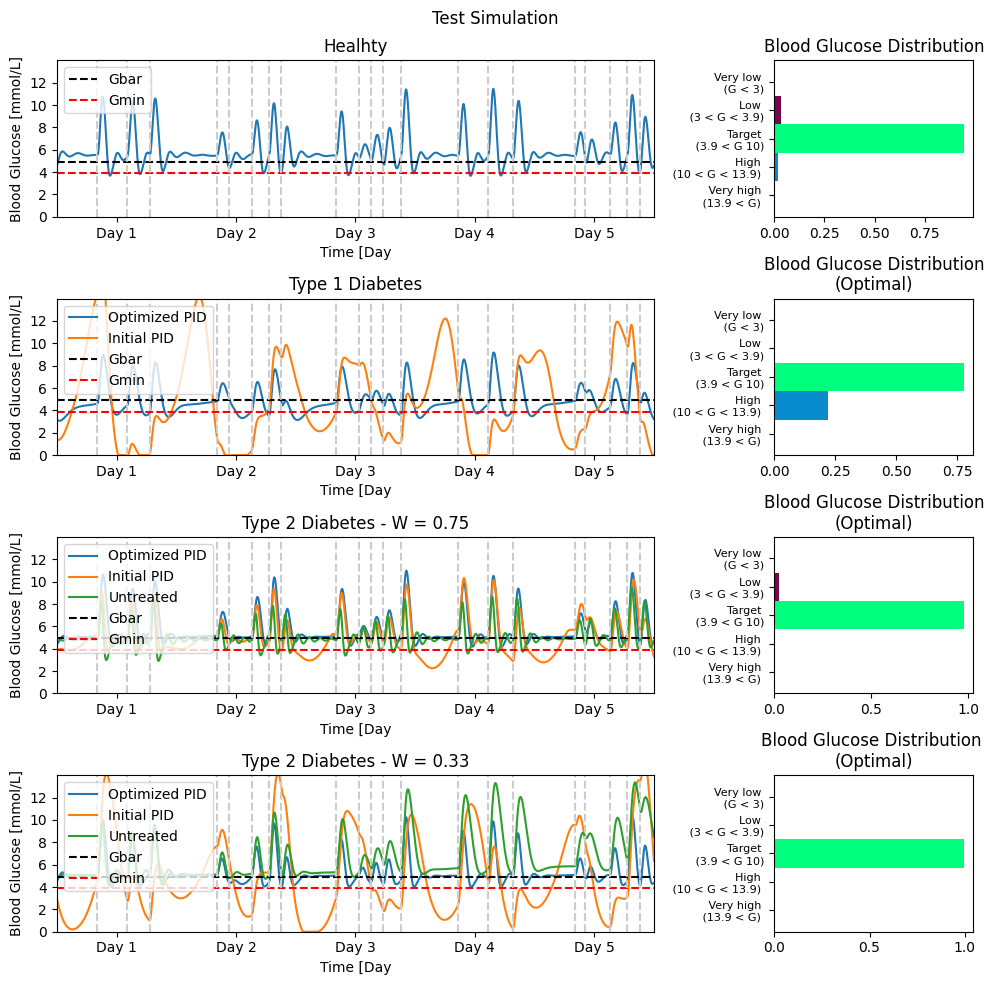

In [31]:
fig, ax = plt.subplots(4,2, figsize = (10,10), width_ratios=[3, 1])
t_arr = info0["t"]/60/24 + 1
fig.suptitle("Test Simulation")
ax[0,0].plot(t_arr, info0["G"])
ax[1,0].plot(t_arr, info1["G"], label = "Optimized PID")
ax[1,0].plot(t_arr, info1_initial["G"], label = "Initial PID")

ax[2,0].plot(t_arr, info2["G"], label = "Optimized PID")
ax[2,0].plot(t_arr, info2_initial["G"], label = "Initial PID")
ax[2,0].plot(t_arr, info2_untreated["G"], label = "Untreated")

ax[3,0].plot(t_arr, info22["G"], label = "Optimized PID")
ax[3,0].plot(t_arr, info22_initial["G"], label = "Initial PID")
ax[3,0].plot(t_arr, info22_untreated["G"], label = "Untreated")

ax[0,0].set_title("Healhty")
ax[1,0].set_title("Type 1 Diabetes")
ax[2,0].set_title(f"Type 2 Diabetes - W = {p2.pancreasObj.W}")
ax[3,0].set_title(f"Type 2 Diabetes - W = {p22.pancreasObj.W}")

hist(info0["G"], ax[0,1])
hist(info1["G"], ax[1,1])
hist(info2["G"], ax[2,1])
hist(info22["G"], ax[3,1])
ax[0,1].set_title("Blood Glucose Distribution")
ax[1,1].set_title("Blood Glucose Distribution\n(Optimal)")
ax[2,1].set_title("Blood Glucose Distribution\n(Optimal)")
ax[3,1].set_title("Blood Glucose Distribution \n(Optimal)")


for i in range(4):
    ax[i,0].set_xticks(np.arange(1.5, 6.5),[f"Day {j}" for j in range(1, 6)])
    ax[i,0].set_xlim(0, t_arr[-1])
    ax[i,0].axhline(p1.Gbar, color="000", linestyle="--", label = "Gbar")
    ax[i,0].axhline(p1.Gmin, color="r", linestyle="--", label = "Gmin")
    ax[i,0].legend(loc = "upper left")
    ax[i,0].set_ylim(0, 14)
    ax[i,0].set_yticks(np.arange(0, 14, 2))
    ax[i,0].set_xlim(1, 6)
    ax[i,0].set_xlabel("Time [Day")
    ax[i,0].set_ylabel("Blood Glucose [mmol/L]")

    for d, day in enumerate(days_test):
        for m in days[day]:
            ts = m[1:].mean()
            ax[i,0].axvline(1+ts/24+d, color="#ccc", linestyle="--")

fig.tight_layout()

In [32]:
def meal_table(meals, num):
    start = meals[:, 1] 
    end = meals[:, 2]
    inner = "\multicolumn{2}{c}{Day "+ str(num) +"} \\\\ \\hline \nTime & Meal size (g. carbs) \\\\ \\hline \n"
    for m in meals:
        start, end = [f"{str(int(m[i+1])).zfill(2)}:{str(int(60*(m[i+1]%1))).zfill(2)}" for i in range(2)]
        row = f"{start}-{end} & {int(m[0])} \\\\ \\hline \n"
        inner += row
    return "\\begin{table}[]\n\\begin{tabular}{|"+"".join(["r|" for i in range(n)])+"}\\hline \n"+inner+"\\end{tabular}\n\\end{table}"
for i, day in enumerate(days):
    print(meal_table(day, i))

\begin{table}[]
\begin{tabular}{|r|r|r|r|r|r|r|}\hline 
\multicolumn{2}{c}{Day 0} \\ \hline 
Time & Meal size (g. carbs) \\ \hline 
06:00-06:15 & 50 \\ \hline 
10:00-10:15 & 20 \\ \hline 
12:30-12:45 & 70 \\ \hline 
15:00-15:15 & 20 \\ \hline 
18:30-18:45 & 80 \\ \hline 
20:00-20:15 & 20 \\ \hline 
\end{tabular}
\end{table}
\begin{table}[]
\begin{tabular}{|r|r|r|r|r|r|r|}\hline 
\multicolumn{2}{c}{Day 1} \\ \hline 
Time & Meal size (g. carbs) \\ \hline 
07:00-07:15 & 100 \\ \hline 
13:30-12:45 & 80 \\ \hline 
18:30-18:45 & 100 \\ \hline 
\end{tabular}
\end{table}
\begin{table}[]
\begin{tabular}{|r|r|r|r|r|r|r|}\hline 
\multicolumn{2}{c}{Day 2} \\ \hline 
Time & Meal size (g. carbs) \\ \hline 
07:30-07:45 & 50 \\ \hline 
10:00-10:15 & 20 \\ \hline 
15:00-15:15 & 50 \\ \hline 
18:30-18:45 & 70 \\ \hline 
21:00-21:15 & 20 \\ \hline 
\end{tabular}
\end{table}
\begin{table}[]
\begin{tabular}{|r|r|r|r|r|r|r|}\hline 
\multicolumn{2}{c}{Day 3} \\ \hline 
Time & Meal size (g. carbs) \\ \hline 


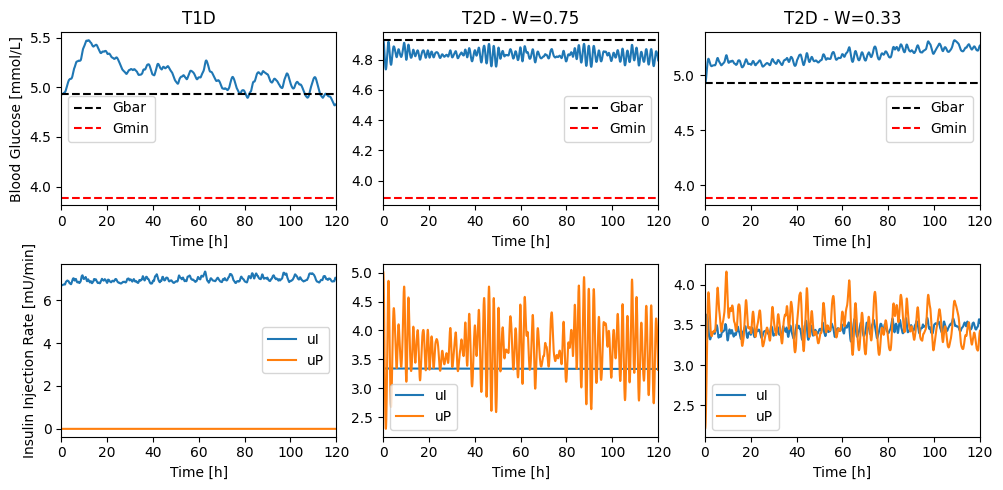

In [41]:
p1.full_reset()
p2.full_reset()
p22.full_reset()

p1.set_PID_params(opt1x)
p2.set_PID_params(opt2x)
p22.set_PID_params(opt22x)

info1noise = p1.simulate(ds = noise)
info2noise = p2.simulate(ds = noise)
info22noise = p22.simulate(ds = noise)

fig, ax = plt.subplots(2, 3, figsize=(10, 5))

for i,info in enumerate([info1noise, info2noise, info22noise]):
    ax[0,i].plot(info["t"]/60,info["G"])
    ax[1,i].plot(info["t"][:-1]/60,info["uI"], label = "uI")
    ax[1,i].plot(info["t"][:-1]/60,info["uP"], label = "uP")
    #ax[0, i].set_ylim(3.5, 6)
    ax[0,i].axhline(p.Gbar, color="000", linestyle="--", label = "Gbar")
    ax[0,i].axhline(p.Gmin, color="r", linestyle="--", label = "Gmin")

    ax[0, i].set_xlim(0, d*24)
    ax[1, i].set_xlim(0, d*24)

    ax[0,i].set_xlabel("Time [h]")
    ax[1,i].set_xlabel("Time [h]")

    ax[0,i].legend()
    ax[1,i].legend()
ax[0,0].set_ylabel("Blood Glucose [mmol/L]")
ax[1,0].set_ylabel("Insulin Injection Rate [mU/min]")
ax[0, 0].set_title("T1D")
ax[0, 1].set_title(f"T2D - W={p2.pancreasObj.W}")
ax[0, 2].set_title(f"T2D - W={p22.pancreasObj.W}")
fig.tight_layout()